In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using LinearAlgebra, Random, Statistics, PyPlot, ProgressMeter

In [2]:
@kwdef mutable struct NN{FT}
    n_batch::UInt32 # batch size
    n_in::UInt32 # number of input units
    n_hid::UInt32 # number of hidden units
    n_out::UInt32 # number of output units
    
    params::Dict{Any, Any} # weights and bias
    grads::Dict{Any, Any} = Dict() # gradient of params
end;

function NN(n_batch, n_in, n_hid, n_out)
    params = Dict()
    params["W1"] = 2(rand(n_in, n_hid) .- 0.5) / sqrt(n_in)
    params["W2"] = 2(rand(n_hid, n_out) .- 0.5) / sqrt(n_hid)
    params["b1"] = zeros(1, n_hid)
    params["b2"] = zeros(1, n_out)
    return NN{Float32}(n_batch=n_batch, n_in=n_in, n_hid=n_hid, n_out=n_out, params=params)
end;

In [3]:
abstract type Optimizer
end

In [4]:
# SGD optimizer
@kwdef struct SGD{FT} <: Optimizer
    η::FT = 1e-2
end

function optimizer_update!(param, grad, optimizer::SGD)
    @unpack η = optimizer
    param[:, :] -= η * grad
end

optimizer_update! (generic function with 1 method)

In [5]:
# Adam optimizer
@kwdef mutable struct Adam{FT} <: Optimizer
    α::FT  = 1e-4
    β1::FT = 0.9
    β2::FT = 0.999
    ϵ::FT = 1e-8
    ms = Dict()
    vs = Dict()
end

# Adam optimizer
function optimizer_update!(param, grad, optimizer::Adam)
    @unpack α, β1, β2, ϵ, ms, vs = optimizer
    key = objectid(param)
    if !haskey(ms, key) 
        ms[key], vs[key] = zeros(size(param)), zeros(size(param))
    end    
    m, v = ms[key], vs[key]
    m += (1 - β1) * (grad - m)
    v += (1 - β2) * (grad .* grad - v)
    param[:, :] -= α * m ./ (sqrt.(v) .+ ϵ)
end

optimizer_update! (generic function with 2 methods)

In [6]:
sigmoid(x) = 1 / (1 + exp(-x));
relu(x) = x .* (x .> 0);

In [7]:
function update!(variable::NN, x::Array, y::Array, training::Bool, optimizer::Optimizer=SGD(), losstype::String="binary_crossentropy")
    @unpack n_batch, params, grads = variable 
    W1, W2, b1, b2 = params["W1"], params["W2"], params["b1"], params["b2"]
    
    # feedforward
    h = sigmoid.(x * W1 .+ b1) # hidden
    ŷ = sigmoid.(h * W2 .+ b2) # output
    error = ŷ - y
    
    if training # backward 
        if losstype == "binary_crossentropy"
            δ2 = error 
        elseif losstype == "squared_error"
            δ2 = error .* ŷ .* (1.0 .- ŷ)
        end
        δ1 = δ2 * W2' .* h .* (1.0 .- h)

        # get gradients
        grads["W1"] = x' * δ1
        grads["W2"] = h' * δ2
        grads["b1"] = sum(δ1, dims=1)
        grads["b2"] = sum(δ2, dims=1)

        # update params
        for key in keys(nn.params) 
            optimizer_update!(params[key], grads[key] / n_batch, optimizer)
        end
    end
    return error, ŷ, h
end

update! (generic function with 3 methods)

In [8]:
# Gaussian 2d
function Gaussian2d(pos, sizex=8, sizey=8, σ=1)
    x, y = 0:sizex-1, 0:sizey-1
    X, Y = [i for i in x, j in 1:length(y)], [j for i in 1:length(x), j in y]
    x0, y0 = pos
    return exp.(-((X .- x0) .^2 + (Y .- y0) .^2) / 2σ^2)
end

Gaussian2d (generic function with 4 methods)

In [9]:
# dataset parameter
θmax = 40.0 # degree, θ∈[-θmax, θmax]
Δθ = 10.0 # degree
stimuli_size = Int(2θmax / Δθ)
w = 15.0 # degree; 1/e width
σ = √2w/(4Δθ);

# training parameter
n_data = 10000
n_traindata = Int(n_data*0.95)
n_batch = 25 # batch size
n_iter_per_epoch = Int(n_traindata/n_batch)
n_epoch = 1000; # number of epoch

In [10]:
# generate positions
Random.seed!(0)
retinal_pos = (rand(n_data, 2) .- 0.5) * 2θmax # ∈ [-40, 40]
head_centered_pos = (rand(n_data, 2) .- 0.5) * 2θmax # ∈ [-40, 40]
eye_pos = head_centered_pos - retinal_pos; # ∈ [-80, 80]

# convert
input_retina = [hcat(Gaussian2d((retinal_pos[i, :] .+ θmax)/Δθ, stimuli_size, stimuli_size, σ)...) for i in 1:n_data];
input_retina = vcat(input_retina...)
eye_pos /= 2θmax;

# concat
x_data = hcat(input_retina, eye_pos) #_encoded)
y_data = vcat([hcat(Gaussian2d((head_centered_pos[i, :] .+ θmax)/Δθ, stimuli_size, stimuli_size, σ)...) for i in 1:n_data]...);

# split
x_traindata, y_traindata = x_data[1:n_traindata, :], y_data[1:n_traindata, :]
x_testdata, y_testdata = x_data[n_traindata+1:end, :], y_data[n_traindata+1:end, :];

In [11]:
# model parameter
n_in = stimuli_size^2 + 2 # number of inputs
n_hid = 16   # number of hidden units
n_out = stimuli_size^2   # number of outputs
η = 1e-2  # learning rate
losstype = "binary_crossentropy" # "squared_error"

nn = NN(n_batch, n_in, n_hid, n_out);
optimizer = SGD(η=η); 
#optimizer = Adam();

In [12]:
error_arr = zeros(Float32, n_epoch); # memory array of each epoch error

@showprogress "Training..." for e in 1:n_epoch
    for iter in 1:n_iter_per_epoch
        idx = (iter-1)*n_batch+1:iter*n_batch
        error, _, _ = update!(nn, x_traindata[idx, :], y_traindata[idx, :], true, optimizer, losstype)
        error_arr[e] += sum(error .^ 2)
    end 
    error_arr[e] /= n_traindata
end

Training...  0%|█                                       |  ETA: 0:38:57

Training...  1%|█                                       |  ETA: 0:04:32

Training...  2%|█                                       |  ETA: 0:03:46

Training...  2%|█                                       |  ETA: 0:03:16

Training...  2%|█                                       |  ETA: 0:02:54

Training...  2%|█                                       |  ETA: 0:02:38

Training...  3%|██                                      |  ETA: 0:02:25

Training...  3%|██                                      |  ETA: 0:02:18

Training...  3%|██                                      |  ETA: 0:02:09

Training...  4%|██                                      |  ETA: 0:02:02

Training...  4%|██                                      |  ETA: 0:01:56

Training...  4%|██                                      |  ETA: 0:01:50

Training...  4%|██                                      |  ETA: 0:01:45

Training...  5%|██                                      |  ETA: 0:01:41

Training...  5%|███                                     |  ETA: 0:01:38

Training...  5%|███                                     |  ETA: 0:01:35

Training...  6%|███                                     |  ETA: 0:01:32

Training...  6%|███                                     |  ETA: 0:01:29

Training...  6%|███                                     |  ETA: 0:01:27

Training...  6%|███                                     |  ETA: 0:01:24

Training...  7%|███                                     |  ETA: 0:01:22

Training...  7%|███                                     |  ETA: 0:01:21

Training...  7%|███                                     |  ETA: 0:01:19

Training...  8%|████                                    |  ETA: 0:01:17

Training...  8%|████                                    |  ETA: 0:01:16

Training...  8%|████                                    |  ETA: 0:01:14

Training...  9%|████                                    |  ETA: 0:01:13

Training...  9%|████                                    |  ETA: 0:01:12

Training...  9%|████                                    |  ETA: 0:01:11

Training... 10%|████                                    |  ETA: 0:01:10

Training... 10%|████                                    |  ETA: 0:01:09

Training... 10%|█████                                   |  ETA: 0:01:07

Training... 10%|█████                                   |  ETA: 0:01:06

Training... 11%|█████                                   |  ETA: 0:01:05

Training... 11%|█████                                   |  ETA: 0:01:04

Training... 11%|█████                                   |  ETA: 0:01:03

Training... 12%|█████                                   |  ETA: 0:01:02

Training... 12%|█████                                   |  ETA: 0:01:00

Training... 12%|██████                                  |  ETA: 0:00:59

Training... 13%|██████                                  |  ETA: 0:00:58

Training... 13%|██████                                  |  ETA: 0:00:57

Training... 14%|██████                                  |  ETA: 0:00:55

Training... 14%|██████                                  |  ETA: 0:00:54

Training... 14%|██████                                  |  ETA: 0:00:53

Training... 15%|██████                                  |  ETA: 0:00:52

Training... 15%|███████                                 |  ETA: 0:00:51

Training... 16%|███████                                 |  ETA: 0:00:50

Training... 16%|███████                                 |  ETA: 0:00:49

Training... 17%|███████                                 |  ETA: 0:00:48

Training... 17%|███████                                 |  ETA: 0:00:47

Training... 18%|████████                                |  ETA: 0:00:46

Training... 18%|████████                                |  ETA: 0:00:46

Training... 18%|████████                                |  ETA: 0:00:45

Training... 19%|████████                                |  ETA: 0:00:44

Training... 19%|████████                                |  ETA: 0:00:44

Training... 20%|████████                                |  ETA: 0:00:43

Training... 20%|█████████                               |  ETA: 0:00:42

Training... 20%|█████████                               |  ETA: 0:00:42

Training... 21%|█████████                               |  ETA: 0:00:41

Training... 21%|█████████                               |  ETA: 0:00:40

Training... 22%|█████████                               |  ETA: 0:00:40

Training... 22%|█████████                               |  ETA: 0:00:39

Training... 23%|██████████                              |  ETA: 0:00:38

Training... 23%|██████████                              |  ETA: 0:00:38

Training... 24%|██████████                              |  ETA: 0:00:37

Training... 24%|██████████                              |  ETA: 0:00:37

Training... 24%|██████████                              |  ETA: 0:00:36

Training... 25%|██████████                              |  ETA: 0:00:36

Training... 25%|███████████                             |  ETA: 0:00:35

Training... 26%|███████████                             |  ETA: 0:00:35

Training... 26%|███████████                             |  ETA: 0:00:34

Training... 27%|███████████                             |  ETA: 0:00:34

Training... 27%|███████████                             |  ETA: 0:00:33

Training... 28%|████████████                            |  ETA: 0:00:33

Training... 28%|████████████                            |  ETA: 0:00:33

Training... 28%|████████████                            |  ETA: 0:00:32

Training... 29%|████████████                            |  ETA: 0:00:32

Training... 29%|████████████                            |  ETA: 0:00:31

Training... 30%|████████████                            |  ETA: 0:00:31

Training... 30%|█████████████                           |  ETA: 0:00:31

Training... 30%|█████████████                           |  ETA: 0:00:31

Training... 31%|█████████████                           |  ETA: 0:00:30

Training... 32%|█████████████                           |  ETA: 0:00:30

Training... 32%|█████████████                           |  ETA: 0:00:29

Training... 32%|█████████████                           |  ETA: 0:00:29

Training... 33%|██████████████                          |  ETA: 0:00:29

Training... 33%|██████████████                          |  ETA: 0:00:28

Training... 34%|██████████████                          |  ETA: 0:00:28

Training... 34%|██████████████                          |  ETA: 0:00:28

Training... 34%|██████████████                          |  ETA: 0:00:28

Training... 35%|██████████████                          |  ETA: 0:00:27

Training... 35%|███████████████                         |  ETA: 0:00:27

Training... 36%|███████████████                         |  ETA: 0:00:27

Training... 36%|███████████████                         |  ETA: 0:00:27

Training... 36%|███████████████                         |  ETA: 0:00:26

Training... 37%|███████████████                         |  ETA: 0:00:26

Training... 37%|███████████████                         |  ETA: 0:00:26

Training... 38%|████████████████                        |  ETA: 0:00:25

Training... 38%|████████████████                        |  ETA: 0:00:25

Training... 38%|████████████████                        |  ETA: 0:00:25

Training... 39%|████████████████                        |  ETA: 0:00:25

Training... 39%|████████████████                        |  ETA: 0:00:24

Training... 40%|████████████████                        |  ETA: 0:00:24

Training... 40%|█████████████████                       |  ETA: 0:00:24

Training... 41%|█████████████████                       |  ETA: 0:00:23

Training... 41%|█████████████████                       |  ETA: 0:00:23

Training... 42%|█████████████████                       |  ETA: 0:00:23

Training... 42%|█████████████████                       |  ETA: 0:00:23

Training... 43%|██████████████████                      |  ETA: 0:00:22

Training... 43%|██████████████████                      |  ETA: 0:00:22

Training... 44%|██████████████████                      |  ETA: 0:00:22

Training... 44%|██████████████████                      |  ETA: 0:00:21

Training... 45%|██████████████████                      |  ETA: 0:00:21

Training... 45%|███████████████████                     |  ETA: 0:00:21

Training... 46%|███████████████████                     |  ETA: 0:00:21

Training... 46%|███████████████████                     |  ETA: 0:00:20

Training... 47%|███████████████████                     |  ETA: 0:00:20

Training... 47%|███████████████████                     |  ETA: 0:00:20

Training... 48%|████████████████████                    |  ETA: 0:00:20

Training... 48%|████████████████████                    |  ETA: 0:00:19

Training... 48%|████████████████████                    |  ETA: 0:00:19

Training... 49%|████████████████████                    |  ETA: 0:00:19

Training... 49%|████████████████████                    |  ETA: 0:00:19[39

m

Training... 50%|████████████████████                    |  ETA: 0:00:19

Training... 50%|█████████████████████                   |  ETA: 0:00:18

Training... 51%|█████████████████████                   |  ETA: 0:00:18

Training... 51%|█████████████████████                   |  ETA: 0:00:18

Training... 52%|█████████████████████                   |  ETA: 0:00:18

Training... 52%|█████████████████████                   |  ETA: 0:00:17

Training... 53%|██████████████████████                  |  ETA: 0:00:17

Training... 53%|██████████████████████                  |  ETA: 0:00:17

Training... 54%|██████████████████████                  |  ETA: 0:00:17

Training... 54%|██████████████████████                  |  ETA: 0:00:17

Training... 55%|██████████████████████                  |  ETA: 0:00:16

Training... 55%|███████████████████████                 |  ETA: 0:00:16

Training... 56%|███████████████████████                 |  ETA: 0:00:16

Training... 56%|███████████████████████                 |  ETA: 0:00:16

Training... 57%|███████████████████████                 |  ETA: 0:00:15

Training... 57%|███████████████████████                 |  ETA: 0:00:15

Training... 58%|████████████████████████                |  ETA: 0:00:15

Training... 58%|████████████████████████                |  ETA: 0:00:15

Training... 58%|████████████████████████                |  ETA: 0:00:15

Training... 59%|████████████████████████                |  ETA: 0:00:14

Training... 59%|████████████████████████                |  ETA: 0:00:14

Training... 60%|████████████████████████                |  ETA: 0:00:14

Training... 60%|█████████████████████████               |  ETA: 0:00:14

Training... 61%|█████████████████████████               |  ETA: 0:00:14

Training... 61%|█████████████████████████               |  ETA: 0:00:13

Training... 62%|█████████████████████████               |  ETA: 0:00:13

Training... 62%|█████████████████████████               |  ETA: 0:00:13

Training... 63%|██████████████████████████              |  ETA: 0:00:13

Training... 63%|██████████████████████████              |  ETA: 0:00:13

Training... 64%|██████████████████████████              |  ETA: 0:00:13

Training... 64%|██████████████████████████              |  ETA: 0:00:12

Training... 64%|██████████████████████████              |  ETA: 0:00:12

Training... 65%|███████████████████████████             |  ETA: 0:00:12

Training... 66%|███████████████████████████             |  ETA: 0:00:12

Training... 66%|███████████████████████████             |  ETA: 0:00:12

Training... 66%|███████████████████████████             |  ETA: 0:00:11

Training... 67%|███████████████████████████             |  ETA: 0:00:11

Training... 68%|████████████████████████████            |  ETA: 0:00:11

Training... 68%|████████████████████████████            |  ETA: 0:00:11

Training... 68%|████████████████████████████            |  ETA: 0:00:11

Training... 69%|████████████████████████████            |  ETA: 0:00:11

Training... 69%|████████████████████████████            |  ETA: 0:00:10

Training... 70%|████████████████████████████            |  ETA: 0:00:10

Training... 70%|█████████████████████████████           |  ETA: 0:00:10

Training... 71%|█████████████████████████████           |  ETA: 0:00:10

Training... 71%|█████████████████████████████           |  ETA: 0:00:10

Training... 72%|█████████████████████████████           |  ETA: 0:00:10

Training... 72%|█████████████████████████████           |  ETA: 0:00:09

Training... 73%|██████████████████████████████          |  ETA: 0:00:09

Training... 73%|██████████████████████████████          |  ETA: 0:00:09

Training... 74%|██████████████████████████████          |  ETA: 0:00:09

Training... 74%|██████████████████████████████          |  ETA: 0:00:09

Training... 74%|██████████████████████████████          |  ETA: 0:00:08

Training... 75%|██████████████████████████████          |  ETA: 0:00:08

Training... 75%|███████████████████████████████         |  ETA: 0:00:08

Training... 76%|███████████████████████████████         |  ETA: 0:00:08

Training... 76%|███████████████████████████████         |  ETA: 0:00:08

Training... 77%|███████████████████████████████         |  ETA: 0:00:08

Training... 77%|███████████████████████████████         |  ETA: 0:00:07

Training... 78%|████████████████████████████████        |  ETA: 0:00:07

Training... 78%|████████████████████████████████        |  ETA: 0:00:07

Training... 79%|████████████████████████████████        |  ETA: 0:00:07

Training... 79%|████████████████████████████████        |  ETA: 0:00:07

Training... 80%|████████████████████████████████        |  ETA: 0:00:07

Training... 80%|█████████████████████████████████       |  ETA: 0:00:06

Training... 81%|█████████████████████████████████       |  ETA: 0:00:06

Training... 81%|█████████████████████████████████       |  ETA: 0:00:06

Training... 82%|█████████████████████████████████       |  ETA: 0:00:06

Training... 82%|█████████████████████████████████       |  ETA: 0:00:06

Training... 83%|██████████████████████████████████      |  ETA: 0:00:06

Training... 83%|██████████████████████████████████      |  ETA: 0:00:05

Training... 84%|██████████████████████████████████      |  ETA: 0:00:05

Training... 84%|██████████████████████████████████      |  ETA: 0:00:05

Training... 84%|██████████████████████████████████      |  ETA: 0:00:05

Training... 85%|██████████████████████████████████      |  ETA: 0:00:05

Training... 85%|███████████████████████████████████     |  ETA: 0:00:05

Training... 86%|███████████████████████████████████     |  ETA: 0:00:05

Training... 86%|███████████████████████████████████     |  ETA: 0:00:04

Training... 87%|███████████████████████████████████     |  ETA: 0:00:04

Training... 87%|███████████████████████████████████     |  ETA: 0:00:04

Training... 88%|████████████████████████████████████    |  ETA: 0:00:04

Training... 88%|████████████████████████████████████    |  ETA: 0:00:04

Training... 89%|████████████████████████████████████    |  ETA: 0:00:04

Training... 89%|████████████████████████████████████    |  ETA: 0:00:03

Training... 90%|████████████████████████████████████    |  ETA: 0:00:03

Training... 90%|█████████████████████████████████████   |  ETA: 0:00:03

Training... 91%|█████████████████████████████████████   |  ETA: 0:00:03

Training... 91%|█████████████████████████████████████   |  ETA: 0:00:03

Training... 92%|█████████████████████████████████████   |  ETA: 0:00:03

Training... 92%|█████████████████████████████████████   |  ETA: 0:00:02

Training... 93%|██████████████████████████████████████  |  ETA: 0:00:02

Training... 93%|██████████████████████████████████████  |  ETA: 0:00:02

Training... 94%|██████████████████████████████████████  |  ETA: 0:00:02

Training... 94%|██████████████████████████████████████  |  ETA: 0:00:02

Training... 95%|██████████████████████████████████████  |  ETA: 0:00:02

Training... 95%|███████████████████████████████████████ |  ETA: 0:00:02

Training... 96%|███████████████████████████████████████ |  ETA: 0:00:01

Training... 96%|███████████████████████████████████████ |  ETA: 0:00:01

Training... 97%|███████████████████████████████████████ |  ETA: 0:00:01

Training... 97%|███████████████████████████████████████ |  ETA: 0:00:01

Training... 98%|████████████████████████████████████████|  ETA: 0:00:01

Training... 98%|████████████████████████████████████████|  ETA: 0:00:01

Training... 98%|████████████████████████████████████████|  ETA: 0:00:01

Training... 99%|████████████████████████████████████████|  ETA: 0:00:00

Training... 99%|████████████████████████████████████████|  ETA: 0:00:00

Training...100%|████████████████████████████████████████|  ETA: 0:00:00

Training...100%|████████████████████████████████████████| Time: 0:00:31


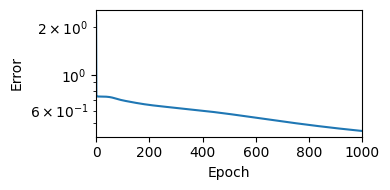

In [13]:
figure(figsize=(4,2))
semilogy(error_arr)
ylabel("Error"); xlabel("Epoch"); xlim(0, n_epoch)
tight_layout()

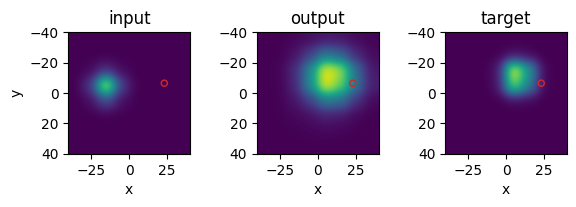

In [14]:
x, y = x_testdata[1:2, :], y_testdata[1:2, :]
error, ŷ, h = update!(nn, x, y, false);

id = 1
figure(figsize=(6,2))
ax1 = subplot(1,3,1); title("input")
ax1.imshow(reshape(x[id, 1:64], (stimuli_size, stimuli_size))', interpolation="gaussian", extent=[-θmax, θmax, θmax, -θmax])
ax1.add_patch(plt.Circle((x[id, 65:66])*2θmax, radius=2, color="tab:red", fill=false))
xlabel("x"); ylabel("y");

ax2 = subplot(1,3,2); title("output")
ax2.imshow(reshape(ŷ[id, :], (stimuli_size, stimuli_size))', interpolation="gaussian", extent=[-θmax, θmax, θmax, -θmax])
ax2.add_patch(plt.Circle((x[id, 65:66])*2θmax, radius=2, color="tab:red", fill=false))
xlabel("x");

ax3 = subplot(1,3,3); title("target")
ax3.imshow(reshape(y[id, :], (stimuli_size, stimuli_size))', interpolation="gaussian", extent=[-θmax, θmax, θmax, -θmax])
ax3.add_patch(plt.Circle((x[id, 65:66])*2θmax, radius=2, color="tab:red", fill=false))
xlabel("x");

tight_layout()

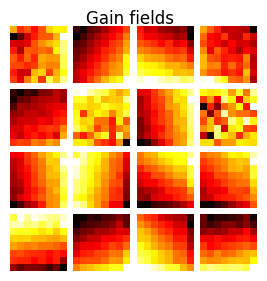

In [15]:
# Plot Gain fields
figure(figsize=(3.2, 3))
suptitle("Gain fields", fontsize=12)
subplots_adjust(hspace=0.1, wspace=0.1, top=0.925)
for i in 1:n_hid
    subplot(4, 4, i)
    imshow(reshape(nn.params["W1"][1:stimuli_size^2, i], (stimuli_size, stimuli_size)), cmap="hot")
    axis("off")
end

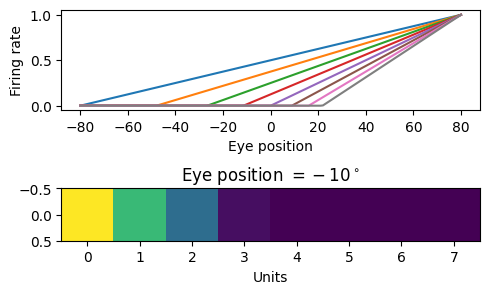

In [16]:
get_line(p1, p2) = [(p2[2]-p1[2])/(p2[1]-p1[1]), (p2[1]*p1[2] - p1[1]*p2[2])/(p2[1]-p1[1])] # [slope, intercept]
eye_pos_coding(x; linear_param) = relu(linear_param[1, :] * x .+ linear_param[2, :])

x = -2θmax:1:2θmax
slope_param = hcat([get_line([80, 1], [-80, -2(i-1)/stimuli_size]) for i in 1:stimuli_size]...)
y = hcat(eye_pos_coding.(x; linear_param=slope_param)...)
eye_pos_encoded = eye_pos_coding(-10; linear_param=slope_param)

figure(figsize=(5,3))
subplot(2,1,1); plot(x, y'); xlabel("Eye position"); ylabel("Firing rate")
subplot(2,1,2); imshow(eye_pos_encoded[:, :]'); title(L"Eye position $=-10^\circ$"); xlabel("Units") 
tight_layout()